In [15]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Thesis/preprocessed-data-WlASL_WLASL_300.zip
!unzip /content/drive/MyDrive/Thesis/landmarks_files_alphabatically_WLASL_300.zip

In [16]:
# neccessary imports
import numpy as np
import pandas as pd
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
import random
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Reshape, Conv1D, BatchNormalization, DepthwiseConv1D, MaxPool1D, GlobalAvgPool1D, Dropout, Dense
from tensorflow.keras import layers, optimizers

In [17]:
FIXED_FRAMES = 25

UNITS = 64 # Transformer

# Transformer
NUM_BLOCKS = 2
MLP_RATIO = 1

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.40
CLASSIFIER_DROPOUT_RATIO = 0.20

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)

# Activations
GELU = tf.keras.activations.gelu

N_EPOCHS = 50
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05
NUM_CLASSES = 300 # Class avalable in WlASL_300

In [40]:
# load data
features = np.load("/content/preprocessed-data-WlASL_WLASL_300/feature_data.npy")
labels = np.load("/content/preprocessed-data-WlASL_WLASL_300/feature_labels.npy")
print(features.shape, labels.shape)

(3185, 30, 104, 3) (3185,)


In [41]:
train_x, val_x, train_y, val_y = train_test_split(features, labels, test_size=0.20, random_state=42)

In [42]:
print(f"Validation X: {val_x.shape}, Validation Y: {val_y.shape}")
print(f"Training X: {train_x.shape}, Training Y: {train_y.shape}")

Validation X: (637, 30, 104, 3), Validation Y: (637,)
Training X: (2548, 30, 104, 3), Training Y: (2548,)


In [43]:
train_x.shape

(2548, 30, 104, 3)

In [44]:
train_y.shape

(2548,)

In [45]:
train_x.shape[1:]

(30, 104, 3)

In [46]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=GELU, kernel_initializer=INIT_HE_UNIFORM())(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def transformer_encoder(x, num_heads, embedding_dim, mlp_dim, dropout_rate):
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, dropout=dropout_rate)(x, x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + attention_output)

    # Preserve the original shape for the MLP and skip the Reshape layer
    mlp_output = mlp(x, hidden_units=[mlp_dim], dropout_rate=dropout_rate)

    # Project the MLP output back to the original embedding dimension
    projected_mlp_output = layers.Dense(embedding_dim, activation=None)(mlp_output) # Project back to original dimension

    # Apply LayerNormalization after the MLP using the original shape
    x = layers.LayerNormalization(epsilon=1e-6)(x + projected_mlp_output)  # Use projected_mlp_output
    return x

def create_swin_transformer_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Embedding layer
    x = layers.Dense(UNITS, activation=GELU, kernel_initializer=INIT_HE_UNIFORM())(inputs)
    x = layers.Dropout(EMBEDDING_DROPOUT)(x)

    # Transformer blocks
    for _ in range(NUM_BLOCKS):
        x = transformer_encoder(x, num_heads=8, embedding_dim=UNITS, mlp_dim=UNITS*MLP_RATIO, dropout_rate=MLP_DROPOUT_RATIO)

    # Reshape before GlobalAveragePooling1D to match expected input shape
    # The -1 infers the batch size, and the remaining dimensions are combined
    # to create the "features" dimension for GlobalAveragePooling1D
    x = layers.Reshape((-1, x.shape[-1]))(x)

    # Classification head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

input_shape = train_x.shape[1:]
model = create_swin_transformer_model(input_shape, NUM_CLASSES)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR_MAX),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [47]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 30, 104, 3)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 30, 104, 64)    │            256 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 30, 104, 64)    │              0 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 30, 104, 64)    │        132,672 │ dropout_12[0][0],      │
│ (MultiHeadAttention)      │                        │                │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 30, 104, 64)    │              0 │ dropout_12[0][0],      │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_8     │ (None, 30, 104, 64)    │            128 │ add_8[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 30, 104, 64)    │          4,160 │ layer_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 30, 104, 64)    │              0 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 30, 104, 64)    │          4,160 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 30, 104, 64)    │              0 │ layer_normalization_8… │
│                           │                        │                │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_9     │ (None, 30, 104, 64)    │            128 │ add_9[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_5    │ (None, 30, 104, 64)    │        132,672 │ layer_normalization_9… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 30, 104, 64)    │              0 │ layer_normalization_9… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_10    │ (None, 30, 104, 64)    │            128 │ add_10[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 30, 104, 64)    │          4,160 │ layer_normalization_1… │
├──────────────────────

 Total params: 302,252 (1.15 MB)

 Trainable params: 302,252 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

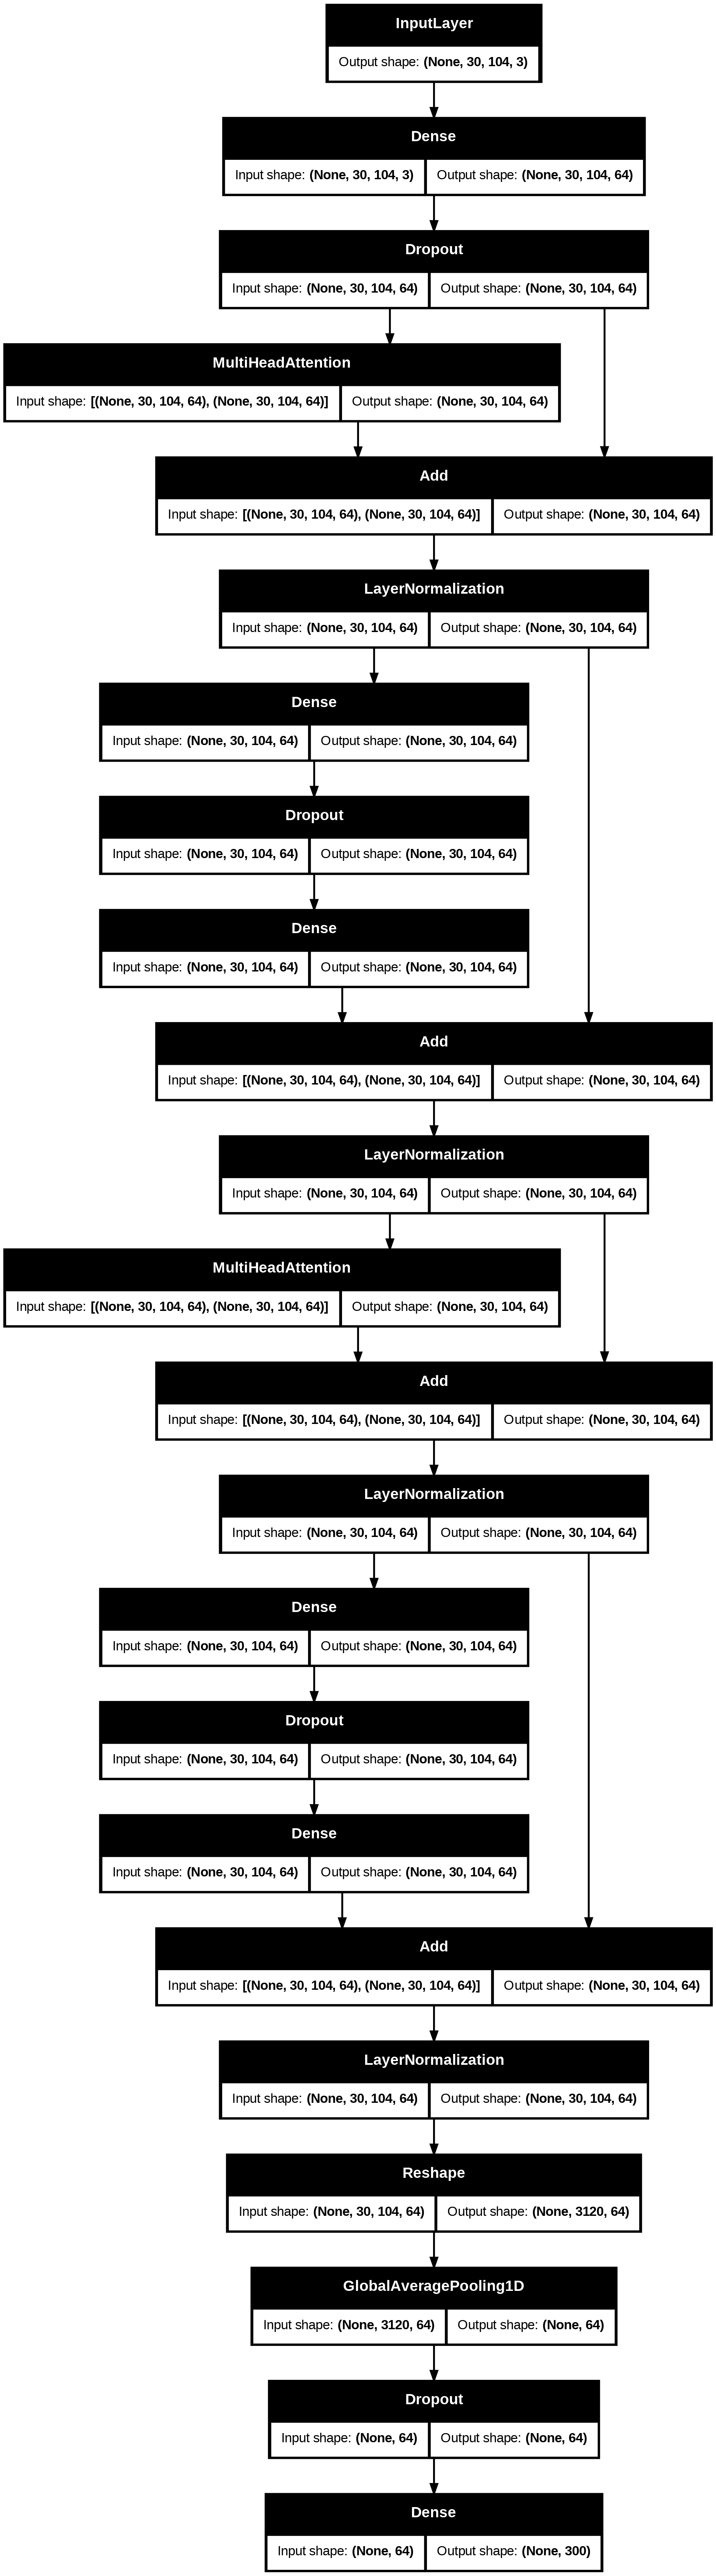

In [48]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.png')

In [49]:
def create_dataset(features, labels, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices((features, labels))
  dataset = dataset.shuffle(buffer_size=len(features)).batch(batch_size)
  return dataset

train_dataset = create_dataset(train_x, train_y, batch_size=8)
val_dataset = create_dataset(val_x, val_y, batch_size=8)


In [52]:
# Define the checkpoint path
checkpoint_path = "/content/drive/MyDrive/swin-checkpoints/swin/checkpoints/cp-{epoch:04d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch') # Save every epoch

In [53]:
#latest checkpoint path before session expired
checkpoint_path = "/content/drive/MyDrive/swin-checkpoints/swin/checkpoints/cp-0046.weights.h5"

# Load the weights into the model
model.load_weights(checkpoint_path)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [54]:
# Set the initial epoch to resume training from the last checkpoint's epoch
initial_epoch = 46

# Continue training the model
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    validation_data=val_dataset,
    callbacks=[cp_callback],
    initial_epoch=initial_epoch
)

Epoch 47/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.3697 - loss: 2.3636
Epoch 47: saving model to /content/drive/MyDrive/swin-checkpoints/swin/checkpoints/cp-0047.weights.h5
319/319 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.3696 - loss: 2.3637 - val_accuracy: 0.0691 - val_loss: 5.7702
Epoch 48/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.4097 - loss: 2.1618
Epoch 48: saving model to /content/drive/MyDrive/swin-checkpoints/swin/checkpoints/cp-0048.weights.h5
319/319 ━━━━━━━━━━━━━━━━━━━━ 363s 972ms/step - accuracy: 0.4096 - loss: 2.1621 - val_accuracy: 0.0848 - val_loss: 5.7809
Epoch 49/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.4141 - loss: 2.1531
Epoch 49: saving model to /content/drive/MyDrive/swin-checkpoints/swin/checkpoints/cp-0049.weights.h5
319/319 ━━━━━━━━━━━━━━━━━━━━ 321s 967ms/step - accuracy: 0.4140 - loss: 2.1533 - val_accuracy: 0.0832 - val_loss: 5.7694
Epoch 50/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 

In [55]:
model.save_weights('model.weights.h5')

In [56]:
!zip -r model.zip model.png model.weights.h5

  adding: model.png (deflated 23%)
  adding: model.weights.h5 (deflated 9%)


In [59]:
!mkdir -p /content/drive/MyDrive/swin
!cp model.zip /content/drive/MyDrive/swin/
!cp model.png /content/drive/MyDrive/swin/
!cp model.weights.h5 /content/drive/MyDrive/swin/

In [60]:
save_path = '/content/'

def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None, save_path=None):
    plt.figure(figsize=(20, 10))

    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')
    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)

    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16)
    plt.yticks(fontsize=16)

    plt.legend(prop={'size': 10})
    plt.grid()

    # Generate a filename based on the metric
    if save_path is None:
        save_path = f'{metric}_plot.png'

    # Save the figure
    plt.savefig(save_path, bbox_inches='tight')

    plt.show()

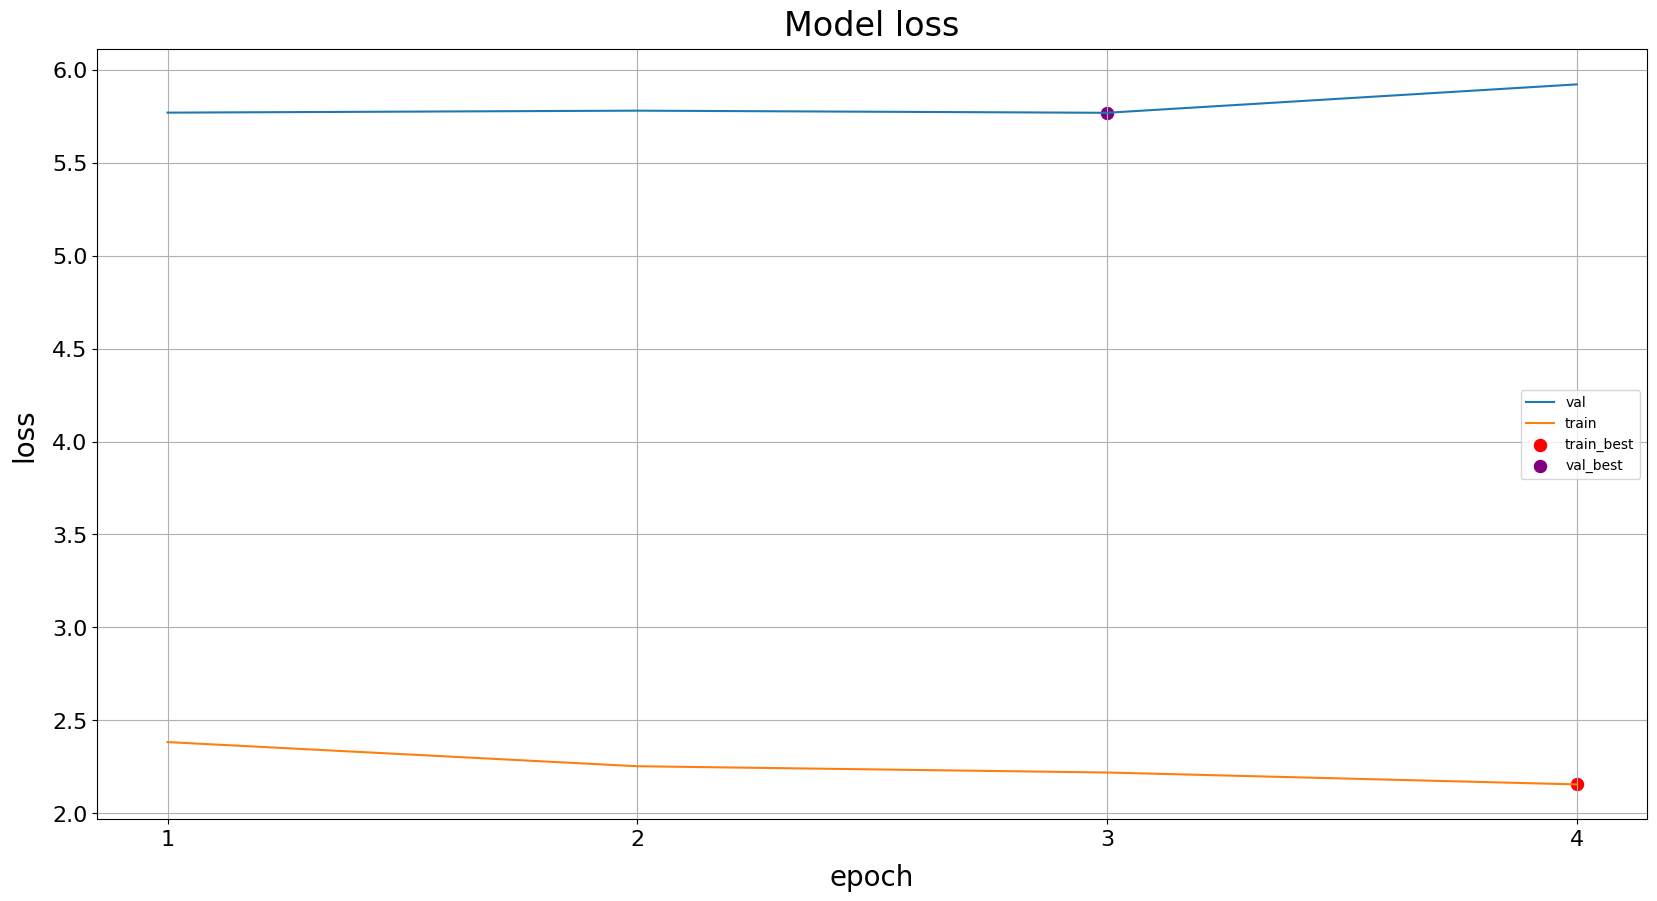

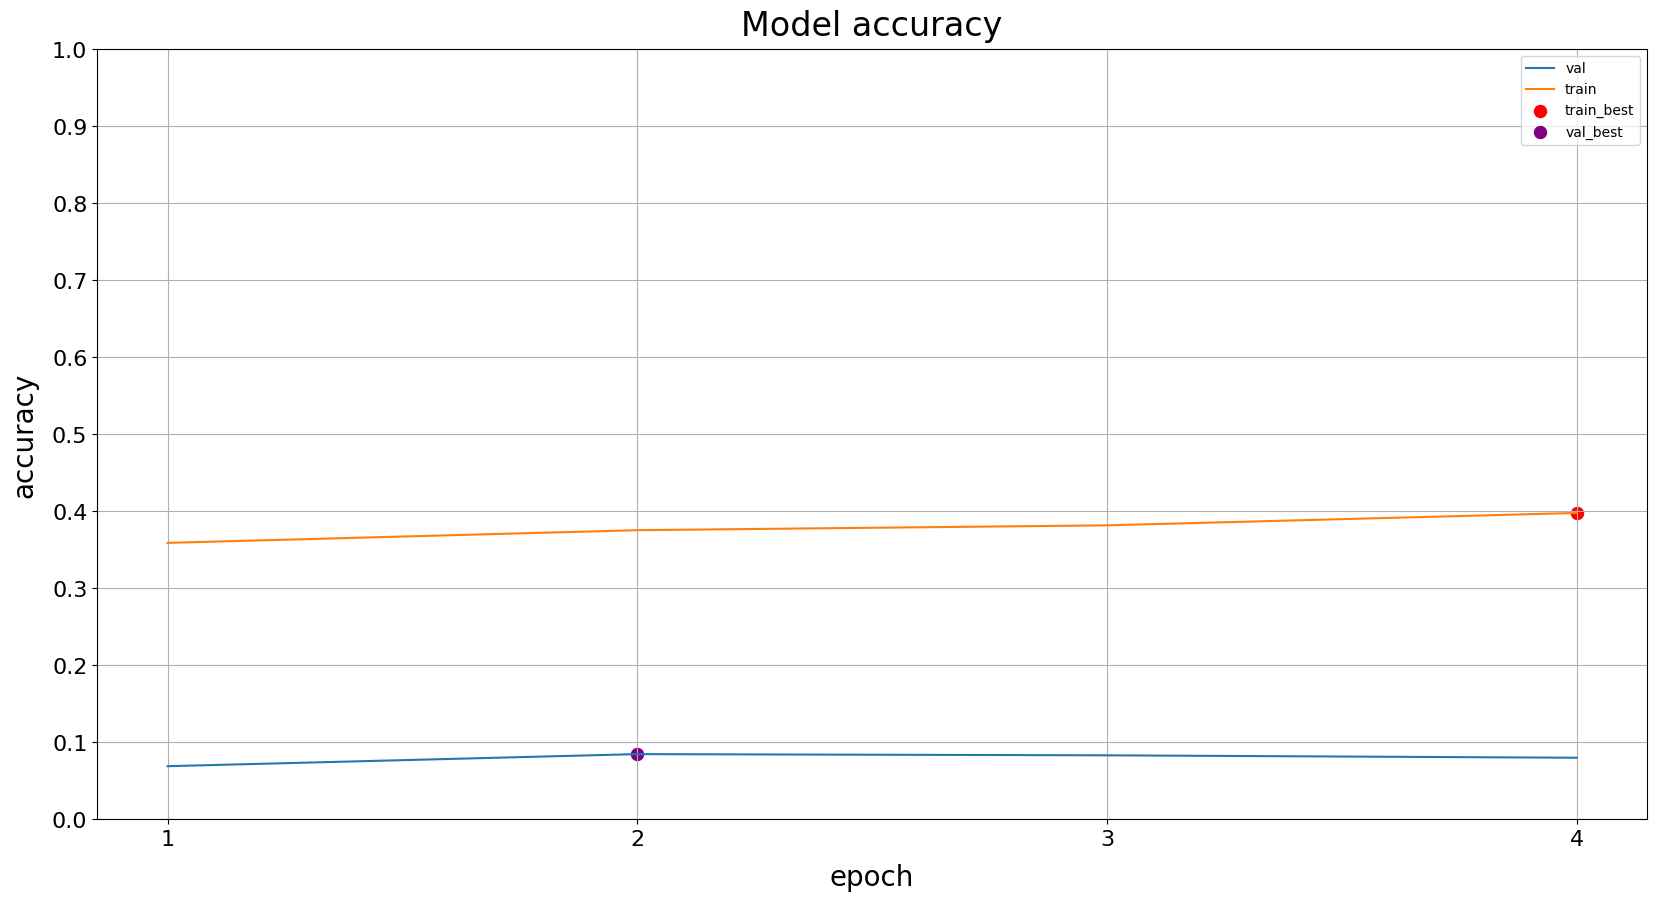

In [61]:
plot_history_metric('loss', f_best=np.argmin, save_path='/content/drive/MyDrive/swin/loss_plot.png')
plot_history_metric('accuracy', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1), save_path='/content/drive/MyDrive/swin/accuracy_plot.png')

In [66]:
model.evaluate(x=val_x, y=val_y,batch_size=8)

80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.0782 - loss: 5.9165


[5.922286033630371, 0.08006279170513153]

80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 223ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Recall: 0.08006279434850863


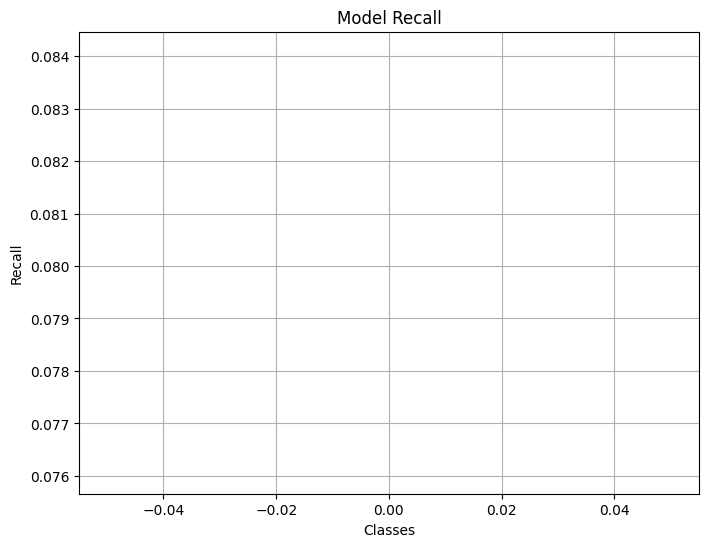

In [70]:
from sklearn.metrics import recall_score

y_pred = model.predict(val_x,batch_size=8)
y_pred_classes = np.argmax(y_pred, axis=1)

recall = recall_score(val_y, y_pred_classes, average='weighted')

print(f"Recall: {recall}")

# Plot the recall
plt.figure(figsize=(8, 6))
plt.plot(recall)
plt.xlabel('Classes')
plt.ylabel('Recall')
plt.title('Model Recall')
plt.grid(True)
plt.show()

In [71]:
signs = []
paths = []

root_folder = r"/content/landmarks_files_(alphabatically)_WLASL_300"

for class_name in os.listdir(root_folder):
    class_path = os.path.join(root_folder, class_name)
    if not os.path.isdir(class_path):
        continue

    for file_name in os.listdir(class_path):
        phrase = class_name
        path = f"/content/landmarks_files_(alphabatically)_WLASL_300/{class_name}/{file_name}"
        signs.append(phrase)
        paths.append(path)
data = {
    'sign': signs,
    'path': paths,
}

train_df = pd.DataFrame(data)

# Converting Signs to Orginal Encodings
train_df['sign_encode'] = train_df['sign'].astype('category').cat.codes

# Dictionary to translate sign to ordinal encoded sign
SIGN_TO_ENCODE = train_df[['sign', 'sign_encode']].set_index('sign').squeeze().to_dict()
ENCODE_TO_SIGN = train_df[['sign_encode', 'sign']].set_index('sign_encode').squeeze().to_dict()


In [73]:
y_val_pred = model.predict(val_x, verbose=2, batch_size=8).argmax(axis=1).astype(np.int32)
labels = [ENCODE_TO_SIGN.get(i, '').replace(' ', '_') for i in range(NUM_CLASSES)]

80/80 - 17s - 210ms/step


In [75]:
from sklearn.metrics import classification_report

# Get model predictions on validation set
y_val_pred_prob = model.predict(val_x, verbose=2, batch_size=8)
y_val_pred = y_val_pred_prob.argmax(axis=1).astype(np.int32)
labels = [ENCODE_TO_SIGN.get(i, '').replace(' ', '_') for i in range(NUM_CLASSES)]

val_y = val_y.astype(np.int32)


# Generate classification report with specified labels parameter
class_report = classification_report(val_y, y_val_pred, labels=np.arange(NUM_CLASSES), target_names=labels)
print("Classification Report:")
print(class_report)


80/80 - 17s - 211ms/step
Classification Report:
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
       a_lot       0.00      0.00      0.00         2
     abdomen       0.75      1.00      0.86         3
        able       0.33      0.50      0.40         2
       about       0.00      0.00      0.00         2
       above       0.00      0.00      0.00         4
      accent       0.00      0.00      0.00         2
      accept       0.06      0.50      0.11         2
    accident       0.00      0.00      0.00         5
  accomplish       0.33      0.25      0.29         4
  accountant       0.00      0.00      0.00         0
      across       0.00      0.00      0.00         2
         act       0.00      0.00      0.00         1
      action       0.00      0.00      0.00         2
      active       0.00      0.00      0.00         6
    activity       0.00      0.00      0.00         2
       actor       0.00      0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me